In [1]:
from sklearn_genetic import GASearchCV
import pandas as pd
from pandas import DataFrame
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn import svm, datasets
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score, make_scorer
from statistics import mean
from sklearn.svm import SVC
from sklearn_genetic.space import Categorical, Integer, Continuous
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import preprocessing
from sklearn.multiclass import OneVsOneClassifier
from sklearn.preprocessing import MinMaxScaler

from sklearn_genetic.plots import plot_fitness_evolution, plot_search_space

In [414]:
#read data
df = pd.read_csv("E:/Thesis/Data/Hasil Preprocessing/4class_3000_sz2_sz2_2_sz6.csv")
df.head()

,Unnamed: 0.1,Unnamed: 0,group,mean,std,median,iqr,mad,NN50_var1,NN50_var2,r_peaks,pNN50_var1,pNN50_var2,sdsd,rmssd,apen,sampen,pasien,class
0,0,0,1,0.713519,0.078063,0.7000,0.11000,0.061207,2.0,24,28,7.142857,85.714286,0.102773,0.100819,0.393578,0.159447,2,2
1,1,1,2,0.680893,0.065093,0.6625,0.06625,0.046084,1.0,26,29,3.448276,89.655172,0.086155,0.084558,0.487029,0.253501,2,2
2,2,2,3,0.669828,0.062342,0.6600,0.05000,0.039120,1.0,27,30,3.333333,90.000000,0.085631,0.084542,0.473740,0.233233,2,2
3,3,3,4,0.647333,0.031724,0.6475,0.04750,0.024667,1.0,28,31,3.225806,90.322581,0.023740,0.023452,0.280811,0.177014,2,2
4,4,4,5,0.656167,0.030589,0.6525,0.05750,0.027578,0.0,29,31,0.000000,93.548387,0.013135,0.013131,0.237859,0.146179,2,2


In [415]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2023 entries, 0 to 2022
Data columns (total 19 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0.1  2023 non-null   int64  
 1   Unnamed: 0    2023 non-null   int64  
 2   group         2023 non-null   int64  
 3   mean          2023 non-null   float64
 4   std           2023 non-null   float64
 5   median        2023 non-null   float64
 6   iqr           2023 non-null   float64
 7   mad           2023 non-null   float64
 8   NN50_var1     2023 non-null   float64
 9   NN50_var2     2023 non-null   int64  
 10  r_peaks       2023 non-null   int64  
 11  pNN50_var1    2023 non-null   float64
 12  pNN50_var2    2023 non-null   float64
 13  sdsd          2023 non-null   float64
 14  rmssd         2023 non-null   float64
 15  apen          2023 non-null   float64
 16  sampen        2023 non-null   float64
 17  pasien        2023 non-null   int64  
 18  class         2023 non-null 

In [416]:
x = df.drop(columns=['Unnamed: 0', 'Unnamed: 0.1', 'pasien', 'class', 'group', 'r_peaks'])

<AxesSubplot:>

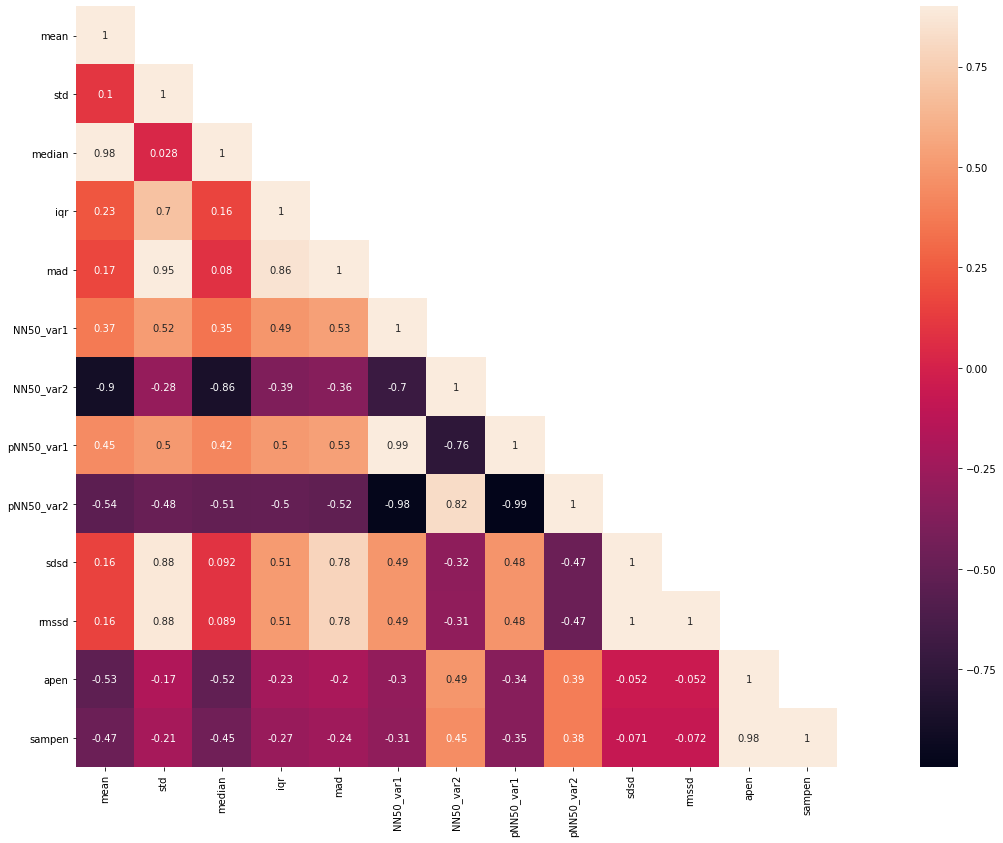

In [417]:
#create correlation
corr = x.corr(method = 'pearson')

#convert correlation to numpy array
mask = np.array(corr)

#to mask the repetitive value for each pair
mask[np.tril_indices_from(mask)] = False
fig, ax = plt.subplots(figsize = (12,8))
fig.set_size_inches(30, 14)
sns.heatmap(corr, mask = mask, vmax = 0.9, square = True, annot = True)

In [418]:
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler
normalised_data = scaler.fit_transform(x)
data = DataFrame(normalised_data)
data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,-0.684122,-0.498988,-0.802817,-0.585185,-0.585140,-0.428571,0.473684,-0.612245,0.617072,-0.491870,-0.489274,-0.013043,-0.547159
1,-0.839833,-0.589421,-0.943662,-0.758025,-0.695334,-0.714286,0.684211,-0.812808,0.809701,-0.579727,-0.577393,0.255464,-0.233990
2,-0.892643,-0.608601,-0.953052,-0.822222,-0.746079,-0.714286,0.789474,-0.819048,0.826556,-0.582500,-0.577479,0.217280,-0.301478
3,-1.000000,-0.822086,-1.000000,-0.832099,-0.851394,-0.714286,0.894737,-0.824885,0.842324,-0.909705,-0.908523,-0.337052,-0.488668
4,-0.957842,-0.830005,-0.981221,-0.792593,-0.830182,-1.000000,1.000000,-1.000000,1.000000,-0.965773,-0.964455,-0.460463,-0.591335


In [419]:
col = list(x.columns)
col = DataFrame(col)
col = col.rename(columns={0: 'Old Column'})
col = col.assign(row_number=range(len(col)))
col

,Old Column,row_number
0,mean,0
1,std,1
2,median,2
3,iqr,3
4,mad,4
5,NN50_var1,5
6,NN50_var2,6
7,pNN50_var1,7
8,pNN50_var2,8
9,sdsd,9


In [420]:
data.rename(columns=col.set_index('row_number')['Old Column'], inplace=True)
data.head()

,mean,std,median,iqr,mad,NN50_var1,NN50_var2,pNN50_var1,pNN50_var2,sdsd,rmssd,apen,sampen
0,-0.684122,-0.498988,-0.802817,-0.585185,-0.585140,-0.428571,0.473684,-0.612245,0.617072,-0.491870,-0.489274,-0.013043,-0.547159
1,-0.839833,-0.589421,-0.943662,-0.758025,-0.695334,-0.714286,0.684211,-0.812808,0.809701,-0.579727,-0.577393,0.255464,-0.233990
2,-0.892643,-0.608601,-0.953052,-0.822222,-0.746079,-0.714286,0.789474,-0.819048,0.826556,-0.582500,-0.577479,0.217280,-0.301478
3,-1.000000,-0.822086,-1.000000,-0.832099,-0.851394,-0.714286,0.894737,-0.824885,0.842324,-0.909705,-0.908523,-0.337052,-0.488668
4,-0.957842,-0.830005,-0.981221,-0.792593,-0.830182,-1.000000,1.000000,-1.000000,1.000000,-0.965773,-0.964455,-0.460463,-0.591335


In [421]:
x = data.to_numpy()

In [422]:
y = df['class']
y = y.to_numpy()

In [423]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0) 
for train_index, test_index in skf.split(x, y): 
    X_train, X_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]

# SVM

# Linear

In [424]:
linear = SVC(kernel='linear', C=990.76, decision_function_shape='ovo', cache_size=2000)
linear = linear.fit(X_train, y_train)
linear_pred = linear.predict(X_train)
confusion_matrix(y_train, linear_pred)

array([[328,   0, 153,   6],
       [  5,   4,   8,   0],
       [ 61,   1, 900,  19],
       [  7,   0,  15, 112]], dtype=int64)

In [425]:
linear_pred = linear.predict(X_test)
confusion_matrix(y_test, linear_pred)

array([[ 76,   0,  44,   2],
       [  0,   1,   3,   0],
       [  9,   0, 234,   2],
       [  1,   0,   4,  28]], dtype=int64)

In [426]:
print(classification_report(y_test, linear_pred))

              precision    recall  f1-score   support

           1       0.88      0.62      0.73       122
           2       1.00      0.25      0.40         4
           3       0.82      0.96      0.88       245
           4       0.88      0.85      0.86        33

    accuracy                           0.84       404
   macro avg       0.89      0.67      0.72       404
weighted avg       0.85      0.84      0.83       404



In [115]:
c = [0.1, 1, 10, 100, 1000]
cr = []
for x in c:
    linear = svm.SVC(kernel='linear', C=x, decision_function_shape='ovo', cache_size=2000)
    linear.fit(X_train, y_train)
    linear_pred = linear.predict(X_train)
    cr.append(classification_report(y_train, linear_pred, output_dict=True))

In [116]:
df_cr_linear = pd.DataFrame(cr)
df_cr_linear

,2,4,accuracy,macro avg,weighted avg
0,"{'precision': 1.0, 'recall': 0.75, 'f1-score':...","{'precision': 0.945054945054945, 'recall': 1.0...",0.952830,"{'precision': 0.9725274725274725, 'recall': 0....","{'precision': 0.955421936554012, 'recall': 0.9..."
1,"{'precision': 1.0, 'recall': 0.75, 'f1-score':...","{'precision': 0.945054945054945, 'recall': 1.0...",0.952830,"{'precision': 0.9725274725274725, 'recall': 0....","{'precision': 0.955421936554012, 'recall': 0.9..."
2,"{'precision': 1.0, 'recall': 0.75, 'f1-score':...","{'precision': 0.945054945054945, 'recall': 1.0...",0.952830,"{'precision': 0.9725274725274725, 'recall': 0....","{'precision': 0.955421936554012, 'recall': 0.9..."
3,"{'precision': 1.0, 'recall': 0.75, 'f1-score':...","{'precision': 0.945054945054945, 'recall': 1.0...",0.952830,"{'precision': 0.9725274725274725, 'recall': 0....","{'precision': 0.955421936554012, 'recall': 0.9..."
4,"{'precision': 1.0, 'recall': 0.775, 'f1-score'...","{'precision': 0.9502762430939227, 'recall': 1....",0.957547,"{'precision': 0.9751381215469613, 'recall': 0....","{'precision': 0.9596580840195977, 'recall': 0...."


In [117]:
df_cr_linear.to_csv('E:/Thesis/Data/Hasil Klasifikasi/Setelah Revisi/2class_3000_sz4_sz6_2_sz7_scaler_3000_linear_training.csv')

# RBF

In [434]:
rbf = svm.SVC(kernel='rbf', C=526.43, gamma =0.85, decision_function_shape='ovo')
rbf.fit(X_train, y_train)
rbf_pred = rbf.predict(X_train)
classification_report(y_train, rbf_pred, output_dict=True)

{'1': {'precision': 0.9845132743362832,
  'recall': 0.9137577002053389,
  'f1-score': 0.9478168264110757,
  'support': 487},
 '2': {'precision': 1.0,
  'recall': 0.9411764705882353,
  'f1-score': 0.9696969696969697,
  'support': 17},
 '3': {'precision': 0.9577187807276303,
  'recall': 0.9928644240570846,
  'f1-score': 0.974974974974975,
  'support': 981},
 '4': {'precision': 0.9925373134328358,
  'recall': 0.9925373134328358,
  'f1-score': 0.9925373134328358,
  'support': 134},
 'accuracy': 0.9684990735021618,
 'macro avg': {'precision': 0.9836923421241873,
  'recall': 0.9600839770708736,
  'f1-score': 0.971256521128964,
  'support': 1619},
 'weighted avg': {'precision': 0.9691044400837401,
  'recall': 0.9684990735021618,
  'f1-score': 0.9682038872127813,
  'support': 1619}}

In [435]:
rbf_pred = rbf.predict(X_test)
confusion_matrix(y_test, rbf_pred)

array([[100,   0,  22,   0],
       [  1,   2,   1,   0],
       [ 10,   3, 230,   2],
       [  0,   0,   1,  32]], dtype=int64)

In [436]:
print(classification_report(y_test, rbf_pred))

              precision    recall  f1-score   support

           1       0.90      0.82      0.86       122
           2       0.40      0.50      0.44         4
           3       0.91      0.94      0.92       245
           4       0.94      0.97      0.96        33

    accuracy                           0.90       404
   macro avg       0.79      0.81      0.79       404
weighted avg       0.90      0.90      0.90       404



In [118]:
cr = []
c = [0.1, 1, 10, 100, 1000]
gamma = [1, 0.1, 0.01, 0.001, 0.0001]
for x in c:
    for i in gamma:
        rbf = svm.SVC(kernel='rbf', C=x, gamma=i, decision_function_shape='ovo')
        rbf.fit(X_train, y_train)
        rbf_pred = rbf.predict(X_train)
        print(classification_report(y_train, rbf_pred))
        cr.append(classification_report(y_train, rbf_pred, output_dict=True))

              precision    recall  f1-score   support

           2       1.00      0.15      0.26        40
           4       0.83      1.00      0.91       172

    accuracy                           0.84       212
   macro avg       0.92      0.57      0.59       212
weighted avg       0.87      0.84      0.79       212

              precision    recall  f1-score   support

           2       1.00      0.53      0.69        40
           4       0.90      1.00      0.95       172

    accuracy                           0.91       212
   macro avg       0.95      0.76      0.82       212
weighted avg       0.92      0.91      0.90       212

              precision    recall  f1-score   support

           2       0.00      0.00      0.00        40
           4       0.81      1.00      0.90       172

    accuracy                           0.81       212
   macro avg       0.41      0.50      0.45       212
weighted avg       0.66      0.81      0.73       212

              preci

C:\Users\zmmah\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\zmmah\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\zmmah\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\zmmah\anaconda3\lib\site-packages\sklearn\metr

              precision    recall  f1-score   support

           2       1.00      0.75      0.86        40
           4       0.95      1.00      0.97       172

    accuracy                           0.95       212
   macro avg       0.97      0.88      0.91       212
weighted avg       0.96      0.95      0.95       212

              precision    recall  f1-score   support

           2       1.00      0.75      0.86        40
           4       0.95      1.00      0.97       172

    accuracy                           0.95       212
   macro avg       0.97      0.88      0.91       212
weighted avg       0.96      0.95      0.95       212

              precision    recall  f1-score   support

           2       1.00      0.55      0.71        40
           4       0.91      1.00      0.95       172

    accuracy                           0.92       212
   macro avg       0.95      0.78      0.83       212
weighted avg       0.92      0.92      0.90       212

              preci

C:\Users\zmmah\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\zmmah\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\zmmah\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\zmmah\anaconda3\lib\site-packages\sklearn\metr

              precision    recall  f1-score   support

           2       1.00      0.78      0.87        40
           4       0.95      1.00      0.97       172

    accuracy                           0.96       212
   macro avg       0.98      0.89      0.92       212
weighted avg       0.96      0.96      0.96       212

              precision    recall  f1-score   support

           2       1.00      0.75      0.86        40
           4       0.95      1.00      0.97       172

    accuracy                           0.95       212
   macro avg       0.97      0.88      0.91       212
weighted avg       0.96      0.95      0.95       212

              precision    recall  f1-score   support

           2       1.00      0.75      0.86        40
           4       0.95      1.00      0.97       172

    accuracy                           0.95       212
   macro avg       0.97      0.88      0.91       212
weighted avg       0.96      0.95      0.95       212

              preci

C:\Users\zmmah\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\zmmah\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\zmmah\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\zmmah\anaconda3\lib\site-packages\sklearn\metr

              precision    recall  f1-score   support

           2       1.00      0.75      0.86        40
           4       0.95      1.00      0.97       172

    accuracy                           0.95       212
   macro avg       0.97      0.88      0.91       212
weighted avg       0.96      0.95      0.95       212

              precision    recall  f1-score   support

           2       1.00      0.75      0.86        40
           4       0.95      1.00      0.97       172

    accuracy                           0.95       212
   macro avg       0.97      0.88      0.91       212
weighted avg       0.96      0.95      0.95       212

              precision    recall  f1-score   support

           2       1.00      0.75      0.86        40
           4       0.95      1.00      0.97       172

    accuracy                           0.95       212
   macro avg       0.97      0.88      0.91       212
weighted avg       0.96      0.95      0.95       212

              preci

In [119]:
df_cr_rbf = pd.DataFrame(cr)

c = [0.1, 1, 10, 100, 1000]
c_new = [a for a in c for i in range(5)]
df_cr_rbf['c'] = c_new
gamma = [1, 0.1, 0.01, 0.001, 0.0001]
gamma_new = gamma * 5
df_cr_rbf['gamma'] = gamma_new
df_cr_rbf

,2,4,accuracy,macro avg,weighted avg,c,gamma
0,"{'precision': 1.0, 'recall': 0.15, 'f1-score':...","{'precision': 0.8349514563106796, 'recall': 1....",0.839623,"{'precision': 0.9174757281553398, 'recall': 0....","{'precision': 0.8660926909690418, 'recall': 0....",0.1,1.0000
1,"{'precision': 1.0, 'recall': 0.525, 'f1-score'...","{'precision': 0.900523560209424, 'recall': 1.0...",0.910377,"{'precision': 0.950261780104712, 'recall': 0.7...","{'precision': 0.9192926997925516, 'recall': 0....",0.1,0.1000
2,"{'precision': 0.0, 'recall': 0.0, 'f1-score': ...","{'precision': 0.8113207547169812, 'recall': 1....",0.811321,"{'precision': 0.4056603773584906, 'recall': 0....","{'precision': 0.658241367034532, 'recall': 0.8...",0.1,0.0100
3,"{'precision': 0.0, 'recall': 0.0, 'f1-score': ...","{'precision': 0.8113207547169812, 'recall': 1....",0.811321,"{'precision': 0.4056603773584906, 'recall': 0....","{'precision': 0.658241367034532, 'recall': 0.8...",0.1,0.0010
4,"{'precision': 0.0, 'recall': 0.0, 'f1-score': ...","{'precision': 0.8113207547169812, 'recall': 1....",0.811321,"{'precision': 0.4056603773584906, 'recall': 0....","{'precision': 0.658241367034532, 'recall': 0.8...",0.1,0.0001
5,"{'precision': 1.0, 'recall': 0.75, 'f1-score':...","{'precision': 0.945054945054945, 'recall': 1.0...",0.952830,"{'precision': 0.9725274725274725, 'recall': 0....","{'precision': 0.955421936554012, 'recall': 0.9...",1.0,1.0000
6,"{'precision': 1.0, 'recall': 0.75, 'f1-score':...","{'precision': 0.945054945054945, 'recall': 1.0...",0.952830,"{'precision': 0.9725274725274725, 'recall': 0....","{'precision': 0.955421936554012, 'recall': 0.9...",1.0,0.1000
7,"{'precision': 1.0, 'recall': 0.55, 'f1-score':...","{'precision': 0.9052631578947369, 'recall': 1....",0.915094,"{'precision': 0.9526315789473685, 'recall': 0....","{'precision': 0.9231380337636544, 'recall': 0....",1.0,0.0100
8,"{'precision': 0.0, 'recall': 0.0, 'f1-score': ...","{'precision': 0.8113207547169812, 'recall': 1....",0.811321,"{'precision': 0.4056603773584906, 'recall': 0....","{'precision': 0.658241367034532, 'recall': 0.8...",1.0,0.0010
9,"{'precision': 0.0, 'recall': 0.0, 'f1-score': ...","{'precision': 0.8113207547169812, 'recall': 1....",0.811321,"{'precision': 0.4056603773584906, 'recall': 0....","{'precision': 0.658241367034532, 'recall': 0.8...",1.0,0.0001


In [120]:
df_cr_rbf.to_csv('E:/Thesis/Data/Hasil Klasifikasi/Setelah Revisi/2class_3000_sz4_sz6_2_sz7_scaler_3000_rbf_training.csv')

# Polynomial

In [428]:
poly = svm.SVC(kernel='poly', C=972.94, degree =1, decision_function_shape='ovo')
poly.fit(X_train, y_train)
poly_pred = poly.predict(X_train)
classification_report(y_train, poly_pred, output_dict=True)

{'1': {'precision': 0.826530612244898,
  'recall': 0.6652977412731006,
  'f1-score': 0.7372013651877133,
  'support': 487},
 '2': {'precision': 0.6666666666666666,
  'recall': 0.23529411764705882,
  'f1-score': 0.3478260869565218,
  'support': 17},
 '3': {'precision': 0.8339483394833949,
  'recall': 0.9215086646279307,
  'f1-score': 0.875544794188862,
  'support': 981},
 '4': {'precision': 0.8175182481751825,
  'recall': 0.835820895522388,
  'f1-score': 0.8265682656826567,
  'support': 134},
 'accuracy': 0.830142063001853,
 'macro avg': {'precision': 0.7861659666425355,
  'recall': 0.6644803547676195,
  'f1-score': 0.6967851280039384,
  'support': 1619},
 'weighted avg': {'precision': 0.8286006842404469,
  'recall': 0.830142063001853,
  'f1-score': 0.8243358239811162,
  'support': 1619}}

In [429]:
poly_pred = poly.predict(X_test)
confusion_matrix(y_test, poly_pred)

array([[ 74,   0,  46,   2],
       [  0,   1,   3,   0],
       [ 11,   0, 232,   2],
       [  1,   0,   4,  28]], dtype=int64)

In [430]:
print(classification_report(y_test, poly_pred))

              precision    recall  f1-score   support

           1       0.86      0.61      0.71       122
           2       1.00      0.25      0.40         4
           3       0.81      0.95      0.88       245
           4       0.88      0.85      0.86        33

    accuracy                           0.83       404
   macro avg       0.89      0.66      0.71       404
weighted avg       0.83      0.83      0.82       404



In [122]:
c = [0.1, 1, 10, 100, 1000]
degree = [1,2,3]
cr = []
for x in c:
    for y in degree:
        poly = svm.SVC(kernel='poly', C=x, degree = y, decision_function_shape='ovo')
        poly.fit(X_train, y_train)
        poly_pred = poly.predict(X_train)
        print(classification_report(y_train, poly_pred))
        cr.append(classification_report(y_train, poly_pred, output_dict=True))

              precision    recall  f1-score   support

           2       1.00      0.55      0.71        40
           4       0.91      1.00      0.95       172

    accuracy                           0.92       212
   macro avg       0.95      0.78      0.83       212
weighted avg       0.92      0.92      0.90       212

              precision    recall  f1-score   support

           2       1.00      0.70      0.82        40
           4       0.93      1.00      0.97       172

    accuracy                           0.94       212
   macro avg       0.97      0.85      0.89       212
weighted avg       0.95      0.94      0.94       212

              precision    recall  f1-score   support

           2       1.00      0.75      0.86        40
           4       0.95      1.00      0.97       172

    accuracy                           0.95       212
   macro avg       0.97      0.88      0.91       212
weighted avg       0.96      0.95      0.95       212

              preci

In [123]:
df_cr_poly = pd.DataFrame(cr)

c = [0.1, 1, 10, 100, 1000]
c_new = [a for a in c for i in range(3)]
df_cr_poly['c'] = c_new
degree = [1,2,3]
degree_new = degree * 5
df_cr_poly['degree'] = degree_new
df_cr_poly

,2,4,accuracy,macro avg,weighted avg,c,degree
0,"{'precision': 1.0, 'recall': 0.55, 'f1-score':...","{'precision': 0.9052631578947369, 'recall': 1....",0.915094,"{'precision': 0.9526315789473685, 'recall': 0....","{'precision': 0.9231380337636544, 'recall': 0....",0.1,1
1,"{'precision': 1.0, 'recall': 0.7, 'f1-score': ...","{'precision': 0.9347826086956522, 'recall': 1....",0.943396,"{'precision': 0.9673913043478262, 'recall': 0....","{'precision': 0.9470877768662839, 'recall': 0....",0.1,2
2,"{'precision': 1.0, 'recall': 0.75, 'f1-score':...","{'precision': 0.945054945054945, 'recall': 1.0...",0.952830,"{'precision': 0.9725274725274725, 'recall': 0....","{'precision': 0.955421936554012, 'recall': 0.9...",0.1,3
3,"{'precision': 1.0, 'recall': 0.75, 'f1-score':...","{'precision': 0.945054945054945, 'recall': 1.0...",0.952830,"{'precision': 0.9725274725274725, 'recall': 0....","{'precision': 0.955421936554012, 'recall': 0.9...",1.0,1
4,"{'precision': 1.0, 'recall': 0.75, 'f1-score':...","{'precision': 0.945054945054945, 'recall': 1.0...",0.952830,"{'precision': 0.9725274725274725, 'recall': 0....","{'precision': 0.955421936554012, 'recall': 0.9...",1.0,2
5,"{'precision': 1.0, 'recall': 0.75, 'f1-score':...","{'precision': 0.945054945054945, 'recall': 1.0...",0.952830,"{'precision': 0.9725274725274725, 'recall': 0....","{'precision': 0.955421936554012, 'recall': 0.9...",1.0,3
6,"{'precision': 1.0, 'recall': 0.75, 'f1-score':...","{'precision': 0.945054945054945, 'recall': 1.0...",0.952830,"{'precision': 0.9725274725274725, 'recall': 0....","{'precision': 0.955421936554012, 'recall': 0.9...",10.0,1
7,"{'precision': 1.0, 'recall': 0.75, 'f1-score':...","{'precision': 0.945054945054945, 'recall': 1.0...",0.952830,"{'precision': 0.9725274725274725, 'recall': 0....","{'precision': 0.955421936554012, 'recall': 0.9...",10.0,2
8,"{'precision': 1.0, 'recall': 0.75, 'f1-score':...","{'precision': 0.945054945054945, 'recall': 1.0...",0.952830,"{'precision': 0.9725274725274725, 'recall': 0....","{'precision': 0.955421936554012, 'recall': 0.9...",10.0,3
9,"{'precision': 1.0, 'recall': 0.75, 'f1-score':...","{'precision': 0.945054945054945, 'recall': 1.0...",0.952830,"{'precision': 0.9725274725274725, 'recall': 0....","{'precision': 0.955421936554012, 'recall': 0.9...",100.0,1


In [124]:
df_cr_poly.to_csv('E:/Thesis/Data/Hasil Klasifikasi/Setelah Revisi/2class_3000_sz4_sz6_2_sz7_scaler_3000_poly_training.csv')

# ---------------------------------------------------------------------------------------------------------------

# SVM - GA

# Polynomial

In [54]:
poly_ga = svm.SVC(kernel='poly', decision_function_shape='ovo')
poly_ga

SVC(decision_function_shape='ovo', kernel='poly')

In [55]:
param_grid = {'C': Continuous(0.1,1000),
              'degree': Integer(1,3)}

cv = StratifiedKFold(n_splits=5, shuffle=True)

evolved_estimator = GASearchCV(estimator=poly_ga,
                               cv=cv,
                               scoring='accuracy',
                               population_size=100,
                               generations=1000,
                               tournament_size=3,
                               elitism=True,
                               crossover_probability=0.6,
                               mutation_probability=0.01,
                               param_grid=param_grid,
                               criteria='max',
                               algorithm='eaMuPlusLambda',
                               n_jobs=-1,
                               verbose=True,
                               keep_top_k=4)

In [56]:
evolved_estimator.fit(X_train,y_train)

gen	nevals	fitness	fitness_std	fitness_max	fitness_min
0  	100   	0.89602	0.0093908  	0.914851   	0.873267   
1  	124   	0.905248	0.00681013 	0.914851   	0.887129   
2  	129   	0.909782	0.00502768 	0.918812   	0.889109   
3  	126   	0.912535	0.00386068 	0.920792   	0.89901    
4  	133   	0.914218	0.00394929 	0.922772   	0.89901    
5  	128   	0.915723	0.00360069 	0.922772   	0.90495    
6  	127   	0.917109	0.00343003 	0.928713   	0.908911   
7  	120   	0.91901 	0.00373098 	0.928713   	0.914851   
8  	105   	0.920436	0.00404251 	0.928713   	0.906931   
9  	122   	0.921564	0.00436448 	0.928713   	0.906931   
10 	126   	0.921941	0.00495588 	0.928713   	0.90297    
11 	127   	0.922891	0.00579234 	0.928713   	0.90099    
12 	116   	0.924851	0.00506695 	0.928713   	0.90099    
13 	126   	0.92598 	0.00494479 	0.928713   	0.90495    
14 	120   	0.927069	0.00434792 	0.928713   	0.910891   
15 	111   	0.927248	0.00492763 	0.928713   	0.89901    
16 	112   	0.927188	0.00475128 	0.928713   	0.9049

GASearchCV(crossover_probability=0.6,
           cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
           estimator=SVC(C=366.3840036855986, decision_function_shape='ovo',
                         kernel='poly'),
           generations=1000, keep_top_k=4, mutation_probability=0.01, n_jobs=-1,
           param_grid={'C': <sklearn_genetic.space.space.Continuous object at 0x00000182A11B4280>,
                       'degree': <sklearn_genetic.space.space.Integer object at 0x00000182A11B4550>},
           population_size=100, return_train_score=True, scoring='accuracy')

In [57]:
y_predicy_ga = evolved_estimator.predict(X_test)
accuracy_score(y_test,y_predicy_ga)

0.9126984126984127

In [58]:
print(classification_report(y_test, y_predicy_ga))

              precision    recall  f1-score   support

           2       0.62      0.57      0.59        14
           3       0.87      0.89      0.88        46
           4       1.00      1.00      1.00        66

    accuracy                           0.91       126
   macro avg       0.83      0.82      0.82       126
weighted avg       0.91      0.91      0.91       126



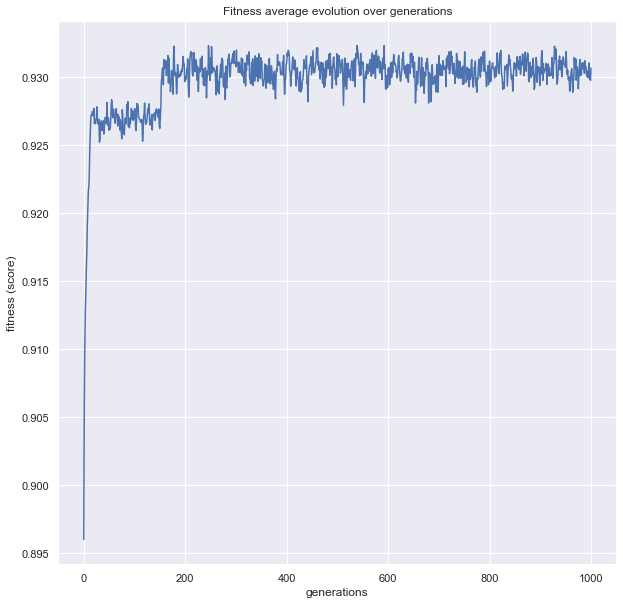

In [59]:
plot_fitness_evolution(evolved_estimator)
plt.show()

# RBF

In [61]:
rbf_ga = svm.SVC(kernel='rbf', decision_function_shape='ovo')
rbf_ga

SVC(decision_function_shape='ovo')

In [69]:
param_grid = {'C': Continuous(0.1,1000),
              'gamma': Continuous(0.0001, 1)}

cv = StratifiedKFold(n_splits=5, shuffle=True)

evolved_estimator = GASearchCV(estimator=rbf_ga,
                               cv=cv,
                               scoring='accuracy',
                               population_size=100,
                               generations=1000,
                               tournament_size=3,
                               elitism=True,
                               crossover_probability=0.8,
                               mutation_probability=0.01,
                               param_grid=param_grid,
                               criteria='max',
                               algorithm='eaMuPlusLambda',
                               n_jobs=-1,
                               verbose=True,
                               keep_top_k=4)

In [70]:
evolved_estimator.fit(X_train,y_train)

gen	nevals	fitness 	fitness_std	fitness_max	fitness_min
0  	100   	0.908178	0.0117439  	0.928713   	0.867327   
1  	171   	0.917723	0.0072345  	0.930693   	0.89703    
2  	162   	0.921901	0.00591625 	0.932673   	0.90495    
3  	168   	0.924792	0.00548039 	0.938614   	0.908911   
4  	155   	0.926693	0.00508707 	0.938614   	0.912871   
5  	165   	0.928515	0.00501346 	0.938614   	0.906931   
6  	153   	0.929228	0.00495936 	0.938614   	0.912871   
7  	150   	0.929782	0.00432409 	0.938614   	0.914851   
8  	163   	0.92897 	0.00579799 	0.938614   	0.910891   
9  	155   	0.930356	0.00493904 	0.938614   	0.906931   
10 	157   	0.930772	0.00498538 	0.938614   	0.908911   
11 	171   	0.92905 	0.00656193 	0.938614   	0.910891   
12 	165   	0.929168	0.00656073 	0.938614   	0.910891   
13 	164   	0.929564	0.00654518 	0.938614   	0.90099    
14 	161   	0.930574	0.00673162 	0.938614   	0.914851   
15 	157   	0.931802	0.00615023 	0.938614   	0.908911   
16 	163   	0.932257	0.00638776 	0.938614   	0.91

GASearchCV(crossover_probability=0.8,
           cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
           estimator=SVC(C=551.8770761025443, decision_function_shape='ovo',
                         gamma=0.7923028903889103),
           generations=1000, keep_top_k=4, mutation_probability=0.01, n_jobs=-1,
           param_grid={'C': <sklearn_genetic.space.space.Continuous object at 0x00000182F9921A60>,
                       'gamma': <sklearn_genetic.space.space.Continuous object at 0x00000182F9921A90>},
           population_size=100, return_train_score=True, scoring='accuracy')

In [79]:
y_predicy_ga = evolved_estimator.predict(X_test)
accuracy_score(y_test,y_predicy_ga)

0.9047619047619048

In [74]:
print(classification_report(y_test, y_predicy_ga))

              precision    recall  f1-score   support

           2       0.58      0.50      0.54        14
           3       0.85      0.87      0.86        46
           4       0.99      1.00      0.99        66

    accuracy                           0.90       126
   macro avg       0.81      0.79      0.80       126
weighted avg       0.89      0.90      0.89       126



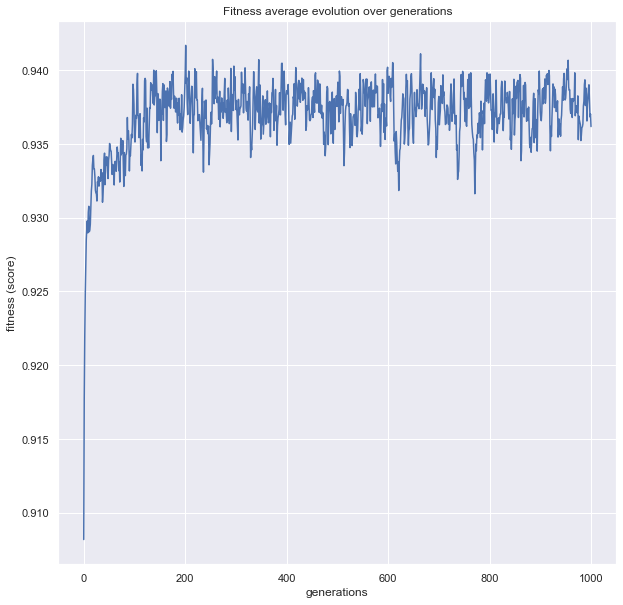

In [75]:
plot_fitness_evolution(evolved_estimator)
plt.show()

# Linear

In [15]:
linear_ga = svm.SVC(kernel='linear', decision_function_shape='ovo')
linear_ga

SVC(decision_function_shape='ovo', kernel='linear')

In [29]:
param_grid = {'C': Continuous(0.1,1000),
              'gamma': Continuous(0.0001, 1)}

cv = StratifiedKFold(n_splits=5, shuffle=True)

evolved_estimator = GASearchCV(estimator=linear_ga,
                               cv=cv,
                               scoring='accuracy',
                               population_size=100,
                               generations=1000,
                               tournament_size=3,
                               elitism=True,
                               crossover_probability=0.6,
                               mutation_probability=0.01,
                               param_grid=param_grid,
                               criteria='max',
                               algorithm='eaMuPlusLambda',
                               n_jobs=-1,
                               verbose=True,
                               keep_top_k=4)

In [30]:
evolved_estimator.fit(X_train,y_train)

gen	nevals	fitness 	fitness_std	fitness_max	fitness_min
0  	100   	0.838314	0.00343713 	0.846816   	0.830148   
1  	129   	0.841205	0.00240473 	0.846816   	0.835084   
2  	135   	0.842842	0.00226817 	0.846816   	0.837543   
3  	119   	0.844244	0.00213806 	0.848666   	0.837553   
4  	118   	0.845282	0.00204636 	0.848689   	0.838186   
5  	127   	0.846318	0.00127256 	0.848689   	0.841259   
6  	115   	0.846584	0.00134494 	0.848689   	0.840634   
7  	124   	0.846895	0.00127704 	0.848689   	0.842489   
8  	133   	0.847198	0.00163219 	0.848689   	0.839393   
9  	117   	0.847089	0.00196326 	0.848689   	0.839418   
10 	121   	0.847529	0.00190341 	0.848689   	0.838784   
11 	135   	0.847637	0.00193421 	0.848689   	0.839401   
12 	123   	0.847708	0.00235943 	0.848689   	0.837553   
13 	121   	0.847932	0.00201078 	0.848689   	0.839418   
14 	123   	0.848131	0.00173689 	0.849301   	0.839409   
15 	114   	0.848069	0.0019825  	0.849301   	0.840638   
16 	120   	0.847889	0.00210225 	0.849301   	0.84

GASearchCV(crossover_probability=0.6,
           cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
           estimator=SVC(C=969.2740606477805, decision_function_shape='ovo',
                         gamma=0.8445804466853966, kernel='linear'),
           generations=1000, keep_top_k=4, mutation_probability=0.01, n_jobs=-1,
           param_grid={'C': <sklearn_genetic.space.space.Continuous object at 0x000001BB481F5100>,
                       'gamma': <sklearn_genetic.space.space.Continuous object at 0x000001BB481F50D0>},
           population_size=100, return_train_score=True, scoring='accuracy')

In [18]:
evolved_estimator

GASearchCV(crossover_probability=0.8,
           cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
           estimator=SVC(C=62.44301879985607, decision_function_shape='ovo',
                         gamma=0.3101056576537188, kernel='linear'),
           generations=1000, keep_top_k=4, mutation_probability=0.01, n_jobs=-1,
           param_grid={'C': <sklearn_genetic.space.space.Continuous object at 0x000001BB132FB5E0>,
                       'gamma': <sklearn_genetic.space.space.Continuous object at 0x000001BB12D37DC0>},
           population_size=100, return_train_score=True, scoring='accuracy')

In [86]:
y_predicy_ga = evolved_estimator.predict(X_test)
accuracy_score(y_test,y_predicy_ga)

0.9206349206349206

In [87]:
print(classification_report(y_test, y_predicy_ga))

              precision    recall  f1-score   support

           2       0.75      0.43      0.55        14
           3       0.85      0.96      0.90        46
           4       1.00      1.00      1.00        66

    accuracy                           0.92       126
   macro avg       0.87      0.80      0.81       126
weighted avg       0.92      0.92      0.91       126



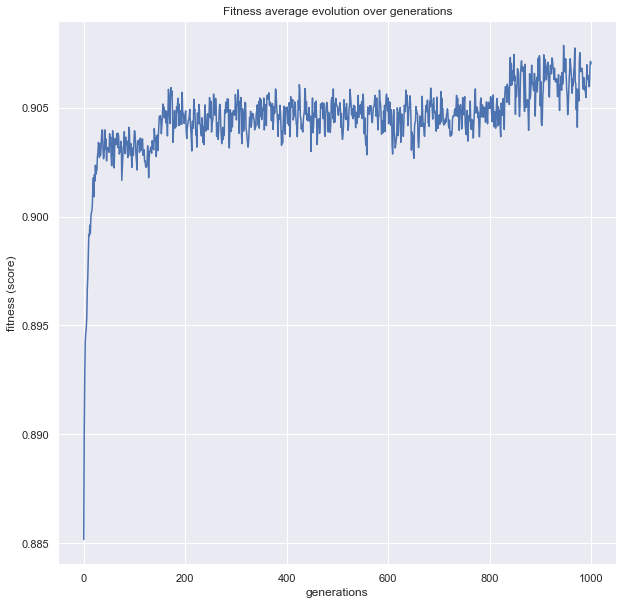

In [88]:
plot_fitness_evolution(evolved_estimator)
plt.show()